# Assignment: E-commerce Customer Data Analysis

**Objective:** In this assignment, you will perform a full data analysis workflow on a synthetically generated e-commerce customer dataset. You will practice data cleaning, encoding, feature engineering, outlier detection, scaling, and visualization. After each major step, you will be required to answer analytical questions.

### Instructions:
1.  Enter the last two digits of your roll number to initialize the random seed. This ensures your dataset is unique but reproducible.
2.  Execute each code cell in order.
3.  After executing a cell block, answer the question(s) in the markdown cell provided below it.

### Enter the last two digits of your roll number

In [1]:
student_roll_number =   28             # ==> CHANGE THIS VALUE SCFP125099 ==>99

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set a seed for reproducibility based on your roll number
np.random.seed(student_roll_number)

# --- Define the number of data points ---
num_customers = 150 + np.random.randint(50)

# --- Generate data for each column ---
customer_ids = np.arange(1001, 1001 + num_customers)
ages = np.random.randint(18, 70, size=num_customers)
regions = np.random.choice(['North', 'South', 'East', 'West'], size=num_customers, p=[0.3, 0.2, 0.25, 0.25])

# Ordinal data: Membership Level
membership_levels = np.random.choice(
    ['Bronze', 'Silver', 'Gold', 'Platinum'],
    size=num_customers,
    p=[0.40, 0.30, 0.20, 0.10]
)

# Numerical data: Total Spend, with some correlation to membership level
spend_base = np.random.normal(loc=1500, scale=400, size=num_customers)
membership_bonus = {'Bronze': 0, 'Silver': 500, 'Gold': 1500, 'Platinum': 3000}
spend_bonuses = np.array([membership_bonus[level] for level in membership_levels])
total_spend = (spend_base + spend_bonuses).astype(int)

# Introduce some high-value outliers
outlier_indices = np.random.choice(num_customers, 4, replace=False)
total_spend[outlier_indices] = [12000, 15500, 19000, 25000]

last_purchase_days_ago = np.random.randint(1, 365, size=num_customers)
has_churned = np.random.choice(['Yes', 'No'], size=num_customers, p=[0.2, 0.8])

# --- Assemble the DataFrame ---
data = {
    'CustomerID': customer_ids,
    'Age': ages,
    'Region': regions,
    'MembershipLevel': membership_levels,
    'TotalSpend': total_spend.astype(float), # Make float to hold NaNs later
    'LastPurchaseDaysAgo': last_purchase_days_ago,
    'HasChurned': has_churned
}
df = pd.DataFrame(data)

# --- Intentionally introduce missing values for the cleaning step ---
spend_missing_indices = df.sample(n=10).index
df.loc[spend_missing_indices, 'TotalSpend'] = np.nan

region_missing_indices = df.sample(n=6).index
df.loc[region_missing_indices, 'Region'] = np.nan

In [3]:
print("First 10 Data Points")
df.head()

First 10 Data Points


,CustomerID,Age,Region,MembershipLevel,TotalSpend,LastPurchaseDaysAgo,HasChurned
0,1001,23,South,Silver,1743.0,292,No
1,1002,40,West,Bronze,1481.0,282,No
2,1003,50,West,Silver,1602.0,129,No
3,1004,21,East,Platinum,4184.0,292,No
4,1005,41,North,Gold,2663.0,48,No


### Part 1: Missing Value Imputation

First, let's identify and handle the missing values in our dataset.

In [5]:
# In[]: Check initial missing values
df.isnull().sum()



CustomerID              0
Age                     0
Region                  6
MembershipLevel         0
TotalSpend             10
LastPurchaseDaysAgo     0
HasChurned              0
dtype: int64

**Question 1.1:** Why is it crucial to identify and handle missing values before proceeding with further analysis or model building?

Now, let's fill the missing values. We'll use the **median** for the numerical `TotalSpend` column and the **mode** for the categorical `Region` column.

In [6]:
# In[]: Fill missing 'TotalSpend' with the median
df['TotalSpend'].fillna(df['TotalSpend'].median(), inplace=True)


In [7]:
# In[]: Fill missing 'Region' with the mode

df['Region'].fillna(df['Region'].mode()[0], inplace=True)

In [8]:
# In[]: Verify that all missing values are handled

df.isnull().sum()

CustomerID             0
Age                    0
Region                 0
MembershipLevel        0
TotalSpend             0
LastPurchaseDaysAgo    0
HasChurned             0
dtype: int64

**Question 1.2:** Explain why the **median** was chosen to impute `TotalSpend` instead of the mean.

**Question 1.3:** Why is the **mode** a suitable choice for imputing a categorical column like `Region`?

### Part 2: Encoding Categorical Data

Machine learning models require numerical input. We need to convert our categorical columns (`Region`, `MembershipLevel`, `HasChurned`) into numbers.

In [9]:
# In[]: Create a copy of the dataframe for encoding
from sklearn.preprocessing import LabelEncoder


In [10]:
# a) One-Hot Encoding for 'Region' (Nominal)

df = pd.get_dummies(df, columns=['Region'], drop_first=True)
df.head()


,CustomerID,Age,MembershipLevel,TotalSpend,LastPurchaseDaysAgo,HasChurned,Region_North,Region_South,Region_West
0,1001,23,Silver,1743.0,292,No,False,True,False
1,1002,40,Bronze,1481.0,282,No,False,False,True
2,1003,50,Silver,1602.0,129,No,False,False,True
3,1004,21,Platinum,4184.0,292,No,False,False,False
4,1005,41,Gold,2663.0,48,No,True,False,False


In [11]:
# b) Label Encoding for 'HasChurned' (Binary-Encode with 0 and 1)
le = LabelEncoder()
df['HasChurned'] = le.fit_transform(df['HasChurned'])
df[['HasChurned']].head()



,HasChurned
0,0
1,0
2,0
3,0
4,0


In [12]:
# c) Ordinal Encoding for 'MembershipLevel'
membership_order = {'Bronze': 1, 'Silver': 2, 'Gold': 3, 'Platinum': 4}
df['MembershipLevel'] = df['MembershipLevel'].map(membership_order)
df[['MembershipLevel']].head()

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           151 non-null    int64  
 1   Age                  151 non-null    int32  
 2   MembershipLevel      151 non-null    int64  
 3   TotalSpend           151 non-null    float64
 4   LastPurchaseDaysAgo  151 non-null    int32  
 5   HasChurned           151 non-null    int64  
 6   Region_North         151 non-null    bool   
 7   Region_South         151 non-null    bool   
 8   Region_West          151 non-null    bool   
dtypes: bool(3), float64(1), int32(2), int64(3)
memory usage: 6.5 KB


**Question 2.1:** Explain the difference between **One-Hot Encoding** and **Ordinal Encoding**. Why was One-Hot Encoding appropriate for `Region` while Ordinal Encoding was appropriate for `MembershipLevel`?

### Part 3: Feature Engineering

Let's create a new feature from existing ones to potentially improve model performance. We will create a `SpendPerDayActive` ratio.

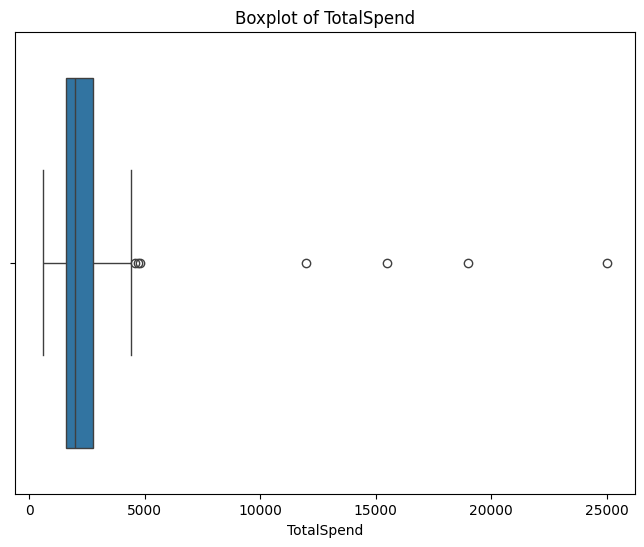

In [13]:
# In[]: Create 'SpendPerDayActive' feature
# We assume the customer has been active for a year (365 days)
# Active days = 365 - LastPurchaseDaysAgo
plt.figure(figsize=(8,6))
sns.boxplot(x=df['TotalSpend'])
plt.title('Boxplot of TotalSpend')
plt.show()


**Question 3.1:** What is the purpose of feature engineering? What potential insight might the new `SpendPerDayActive` feature provide that `TotalSpend` or `LastPurchaseDaysAgo` alone do not?

### Part 4: Outlier Detection

Outliers can significantly skew statistical analyses and machine learning models. We will use two common methods to detect outliers in the `TotalSpend` column.

In [14]:
# In[]: a) Z-Score Method

from scipy import stats
import numpy as np
z_scores = np.abs(stats.zscore(df['TotalSpend']))
z_outliers = df[z_scores > 3]
print("Number of Outliers detecetd by z_score method:", len(z_outliers))
z_outliers.head()


Number of Outliers detecetd by z_score method: 4


,CustomerID,Age,MembershipLevel,TotalSpend,LastPurchaseDaysAgo,HasChurned,Region_North,Region_South,Region_West
29,1030,22,3,15500.0,187,0,False,True,False
72,1073,29,1,12000.0,208,0,False,False,False
74,1075,43,1,25000.0,111,0,True,False,False
104,1105,46,1,19000.0,244,0,False,False,True


In [15]:
# In[]: b) IQR Method

Q1 = df['TotalSpend'].quantile(0.25)
Q3 = df['TotalSpend'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

iqr_outliers = df[(df['TotalSpend'] < lower_limit) | (df['TotalSpend'] > upper_limit)]
print("Number of Outliers detecetd by IQR method:", len(iqr_outliers))
iqr_outliers.head()

Number of Outliers detecetd by IQR method: 7


,CustomerID,Age,MembershipLevel,TotalSpend,LastPurchaseDaysAgo,HasChurned,Region_North,Region_South,Region_West
14,1015,48,4,4790.0,350,0,True,False,False
24,1025,69,4,4716.0,31,0,False,False,True
29,1030,22,3,15500.0,187,0,False,True,False
72,1073,29,1,12000.0,208,0,False,False,False
74,1075,43,1,25000.0,111,0,True,False,False


**Question 4.1:** Compare the outliers detected by the Z-Score method and the IQR method. Are they the same? Why might the results from these two methods differ?

**Question 4.2:** In a real-world scenario, what would be your next step after identifying these outliers? Should they always be removed? Explain your reasoning.

### Part 5: Feature Scaling

Many algorithms perform better when numerical features are on a similar scale. We will apply **Min-Max Scaling** to `Age` and **Standardization** to `TotalSpend`.

In [16]:
# In[]: Copy a dataframe for scaling

df_scaled = df.copy()

In [17]:
# a) Min-Max Scaling on 'Age'
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
df_scaled['Age_Scaled'] = minmax_scaler.fit_transform(df_scaled[['Age']])

df_scaled[['Age', 'Age_Scaled']].head()




,Age,Age_Scaled
0,23,0.098039
1,40,0.431373
2,50,0.627451
3,21,0.058824
4,41,0.450980


In [18]:
# b) Standardization on 'TotalSpend'
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
df_scaled['TotalSpend_Standardized'] = standard_scaler.fit_transform(df_scaled[['TotalSpend']])

df_scaled[['TotalSpend', 'TotalSpend_Standardized']].head()


,TotalSpend,TotalSpend_Standardized
0,1743.0,-0.302581
1,1481.0,-0.397370
2,1602.0,-0.353593
3,4184.0,0.580542
4,2663.0,0.030263


**Question 5.1:** Describe a situation or a type of machine learning algorithm where **Min-Max Scaling** would be preferred over **Standardization**, and vice-versa.

### Part 6: Data Visualization

Visualization is key to understanding data. Let's create a few plots to explore our customer dataset.

In [19]:
# import micropip        # If you wants to run this in MS Teams
# await micropip.install("seaborn")       # If you wants to run this in MS Teams
import seaborn as sns
# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

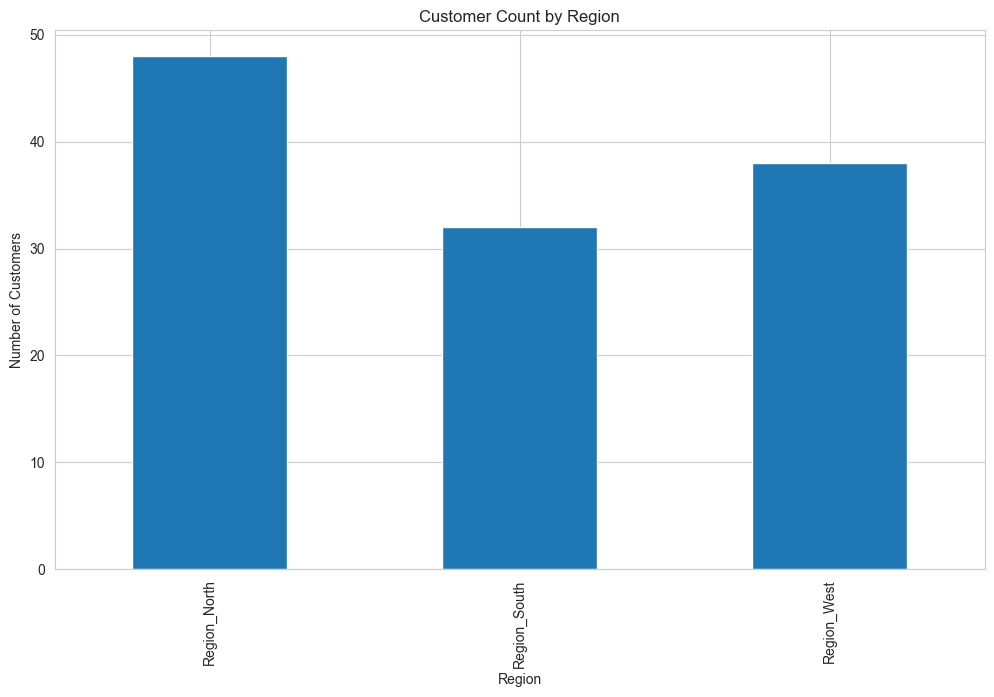

In [20]:
# a) Bar Chart: Customer count by Region
df[[col for col in df.columns if 'Region_' in col]].sum().plot(kind='bar')
plt.title('Customer Count by Region')
plt.xlabel('Region')
plt.ylabel('Number of Customers')
plt.show()


**Question 6.1:** Based on the bar chart, which region has the most customers? Which has the fewest?

**Question 6.2:** What is the dominant membership level among customers in this dataset?

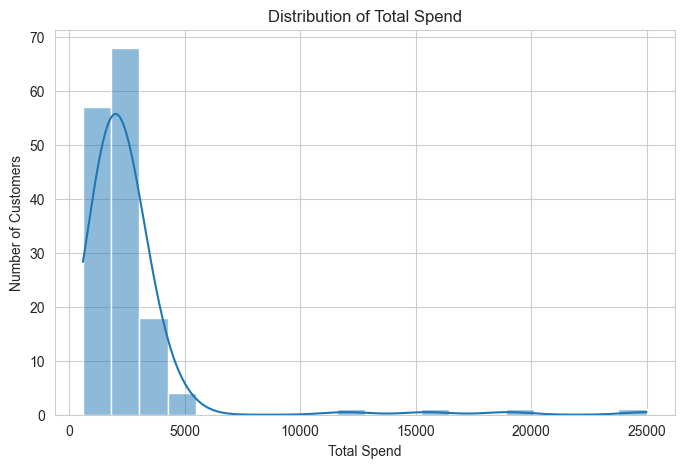

In [21]:
# In[]: c) Histogram: Distribution of Total Spend

plt.figure(figsize=(8,5))
sns.histplot(df['TotalSpend'], bins=20, kde=True)
plt.title('Distribution of Total Spend')
plt.xlabel('Total Spend')
plt.ylabel('Number of Customers')
plt.show()

**Question 6.3:** What does the histogram and the position of the mean/median lines tell you about the distribution of `TotalSpend`? Is the data skewed? If so, in which direction?

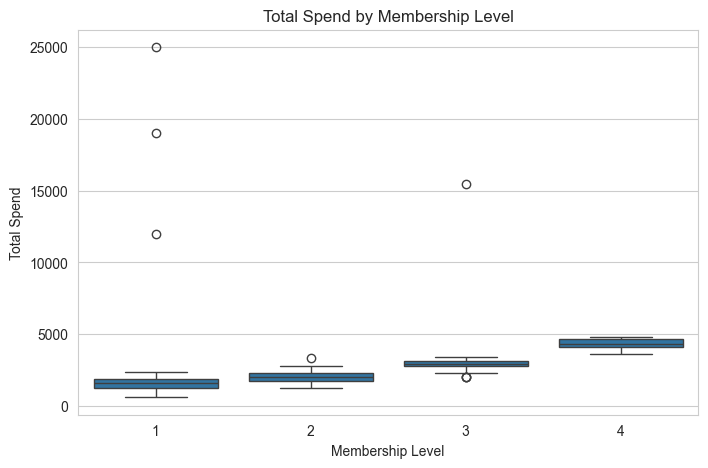

In [22]:
# In[]: d) Box Plot: Total Spend by Membership Level
plt.figure(figsize=(8,5))
sns.boxplot(x='MembershipLevel', y='TotalSpend', data=df)
plt.title('Total Spend by Membership Level')
plt.xlabel('Membership Level')
plt.ylabel('Total Spend')
plt.show()


**Question 6.4:** Based on the box plot, which membership level has the highest median spending? What do the individual dots outside the 'whiskers' represent, and which concept from Part 4 do they relate to?